In [21]:
import SimpleITK as sitk 
import numpy as np 
import matplotlib.pyplot as plt 
import json 
import csv 
import os 
import pandas as pd 
import tensorflow as tf 
from sklearn.model_selection import train_test_split 

from classification.pre_process.Prep_CSV import Prep_CSV
from classification.pre_process.Preprocessing import Preprocessing 
from classification.model.resnet50 import *
from classification.model.unet import *
from utils.modality_CT import *

In [22]:
#chemin des fichiers labelisés à récuperer via le site
json_path = 'Résultats/result.json' 

#un répertoire pour mettre les résultats
nifti_directory = 'Résultats'
objet = Prep_CSV(json_path)
objet.result_csv(nifti_directory)
print(objet.csv_result_path)

Résultats/classif_test_png.csv


In [23]:
prep_objet = Preprocessing(objet.csv_result_path)
X, y = prep_objet.normalize_encoding_dataset()

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42, test_size = 0.15) #random state 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state = 42, test_size = 0.15)

In [25]:
print("size of X_train : ", X_train.shape)
print("size of y_train : ",y_train.shape)
print("")
print("size of X_test : ", X_test.shape)
print("size of y_test : ",y_test.shape)
print("")
print("size of X_val : ", X_val.shape)
print("size of y_val : ",y_val.shape)

size of X_train :  (804, 503, 136, 1)
size of y_train :  (804, 4)

size of X_test :  (168, 503, 136, 1)
size of y_test :  (168, 4)

size of X_val :  (142, 503, 136, 1)
size of y_val :  (142, 4)


(804, 503, 136)


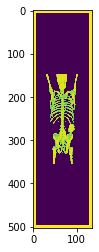

In [14]:
X_train=np.reshape(X_train,(804,503,136))
print(X_train.shape)
plt.imshow(X_train[0]);

In [26]:
model = create_model()
model.summary()

NameError: name 'create_model' is not defined

In [15]:
#model 
#model = ResNet50(input_shape=(503, 136, 1)) #(1024, 256, 1)
#model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 503, 136, 1) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 509, 142, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 252, 68, 64)  3200        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 252, 68, 64)  256         conv1[0][0]                      
___________________________________________________________________________________________

In [16]:
#compile 
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) #param
model.compile(optimizer = optimizer, 
        loss={'left_arm' : 'sparse_categorical_crossentropy', 
            'right_arm' : 'sparse_categorical_crossentropy', 
             'head' : 'sparse_categorical_crossentropy', 
             'leg' : 'sparse_categorical_crossentropy'}, 
        loss_weights ={'left_arm': 0.25, 'right_arm' : 0.25, 
                        'head' : 0.25, 
                        'leg': 0.25}, 
        metrics = {'left_arm': ['accuracy'], #'SparseCategoricalCrossentropy'
                    'right_arm' : ['accuracy'], 
                    'head' : ['accuracy'], 
                    'leg':['accuracy']}) #a voir pour loss

In [17]:
log_dir = 'classification/test/Resnet_png/logs_15_10_2020__head'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

In [18]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, update_freq='epoch', write_graph=True, write_images=True)

In [20]:
#fit 
history = model.fit(X_train, {'head': y_train[:,0], 
                                    'leg': y_train[:,1],
                                    'right_arm' : y_train[:,2],
                                    'left_arm' : y_train[:,3] ,
                                    }, 
                                    
                        epochs = 10, 
                        batch_size = 128, 
                        verbose = 1, 
                        #validation_split= 0.20,
                        validation_data = (X_val, {'head': y_val[:,0], 
                                    'leg': y_val[:,1],
                                    'right_arm' : y_val[:,2],
                                    'left_arm' : y_val[:,3] ,
                                    }),
                        callbacks=[tensorboard_callback])


Epoch 1/10
1/7 [===>..........................] - ETA: 0s - loss: 1.1283 - head_loss: 1.7766 - leg_loss: 0.6316 - right_arm_loss: 1.1128 - left_arm_loss: 0.9923 - head_accuracy: 0.4766 - leg_accuracy: 0.8750 - right_arm_accuracy: 0.7812 - left_arm_accuracy: 0.7109WARNING:tensorflow:From /Library/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
2/7 [=======>......................] - ETA: 4:09 - loss: 0.9085 - head_loss: 1.3978 - leg_loss: 0.5319 - right_arm_loss: 0.8729 - left_arm_loss: 0.8315 - head_accuracy: 0.4961 - leg_accuracy: 0.8789 - right_arm_accuracy: 0.7773 - left_arm_accuracy: 0.7305

KeyboardInterrupt: 